In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cifar10:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5071%2F7665%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T091755Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D89e5c4b6b10cf2bf720c6686083747aa7ac68cdd401f40852db61e5f7d1fb47e623cbff8f7a6919eb505cce3c2c819cb40e4a421826ee08d28b5c3d1502bb50548155c3e4f508d70eb4e2037ef1d576cf9b94e32446acc83d53d307233d5aab32464e4cbd3c7f8d68d6ddfbb029fe7340fc3ceb1ce657c1efedce19f1caa71d4b9f389d51aa4ca716ab2105e18927df189e82bb67228d5ca869e202bb9b39656a8ab6fe31cf807a8ce7b3e412973fe79300d4e8cd9fd8aeb48bbf6f17beeb7939f51ccda37dca95af8fbda54192b27b9ab78b0b1679cca2216bc6ec5dd4d812e87271002dc1e32f0d32f10eec71501eef7dccedb6c67e559b1a02a256011359c,fashionmnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T091755Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D582f4a5be0a7c6ae2857c9eb75d18f4e9800e5c4b9b3c2cea3a2f99085b98ae0bab86d8da218f83b2ce1a9b370391b7713e331d154ef7b00918efb1ea57348204dd77a9390ad6ec7499b6e02d5e8301ef2300df78084e05c44e807bd04073679867dac56de80ea9015ec6cb8d85587665f122b30ae27e857e27de8babd5ece297b5f621dd82c0a70584c7775a57a427ce6c2df4cf7b226355170022d1844f721311240d9d54d8879802db92ee719ee605eda561152d1d453e56291890adf65e54fd52fe36039b3dd5a673dfbd8c7eb9cf1117e30a5e369f335307990dbf72b2b1c5cba34f22588fe5d0f7efa3ac17968648690b774b9df6ac933458a5f44f875,cifar10-python:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F11102%2F15444%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T091755Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0d5efe5eda12195c4c74355903ec5d60c80aa62efd1116f7c908ddf70db3c05504d3bde3bede8c88d9dbd5781ca6740b1bbc18f83a5ffcc49d125c626631b479d0573742d5577d9ee23ef33bb6f9316a38347a6bd300c7bbcaf1e9791becbd242c502bfa7285c5c629832fb9c3734e0c1d255254d35c8e789d486546f85dfce3ba4fe1342221c1041f8c95dfce06854a183e82b21675ccf56e9ab89c4a5d13faeca6fd041a57d3e2fbcc0f95aa1fb6f036308057f037002b91fa5003e0667ae808fa5b08c24b15500fd090a81b382c4ace5eaf652f2c3d35917de73a0db4f37e695561078e75c0e9e0808f51d7fde55be1db0fa8ba0fb6b5eb1a7a4113a11776'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 170062484 bytes downloaded
Downloaded and uncompressed: cifar10
[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: fashionmnist
[==================================================] 340613496 bytes downloaded
Downloaded and uncompressed: cifar10-python
Data source import complete.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Loading Data

In [4]:
(xtrain, ytrain), (xtest, ytest) = cifar10.load_data()
xtrain,xtest=xtrain/255.0,xtest/255.0

170498071/170498071 [==============================] - 3s 0us/step


[1]


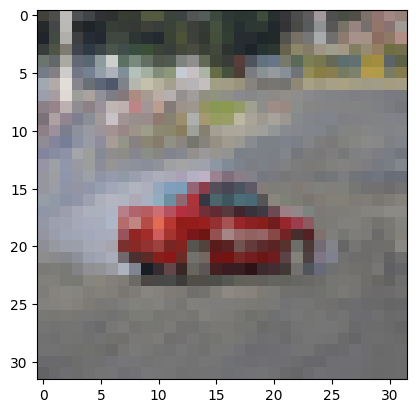

In [5]:
plt.imshow(xtrain[75])
print(ytrain[75])

# Building the model

In [6]:
model1 = Sequential([
    Flatten(input_shape = (32, 32, 3)),
    Dense(units = 700, activation = 'relu'),
    Dropout(0.2),
    Dense(units = 10, activation = 'softmax')
])

In [7]:
model2 = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    # Dense(units=264, activation='relu'),
    # BatchNormalization(),
    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    BatchNormalization(),
    Dense(units=16, activation='relu'),
    BatchNormalization(),
    Dense(units=10, activation='softmax')
])

In [8]:
# model3 = Sequential([
#     Conv2D(264, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')
# ])

In [9]:
# model3 = Sequential([
#     Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=(img_rows, img_cols, 1)),
#     Conv2D(20, kernel_size=(3, 3), activation='relu'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

In [10]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model3 = Sequential()

# Convolutional Layer
model3.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model3.add(BatchNormalization())
# Pooling layer
model3.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model3.add(Dropout(0.25))

model3.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
# model.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(10, activation='softmax'))

In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 700)               2151100   
                                                                 
 dropout (Dropout)           (None, 700)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7010      
                                                                 
Total params: 2158110 (8.23 MB)
Trainable params: 2158110 (8.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1573376   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 64)               

In [13]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                      

In [14]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [15]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy'])
# model1.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model1.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
# model1.compile(optimizer='adagrad', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model1.compile(optimizer='adadelta', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])


In [16]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history_norm = model1.fit(xtrain, ytrain,batch_size=64, epochs=100, validation_data=(xtest, ytest), callbacks=[early_stop])

Epoch 1/100
782/782 [==============================] - 27s 34ms/step - loss: 1.9897 - accuracy: 0.2984 - val_loss: 1.7917 - val_accuracy: 0.3544
Epoch 2/100
782/782 [==============================] - 26s 33ms/step - loss: 1.8053 - accuracy: 0.3504 - val_loss: 1.7075 - val_accuracy: 0.3918
Epoch 3/100
782/782 [==============================] - 26s 33ms/step - loss: 1.7610 - accuracy: 0.3700 - val_loss: 1.6747 - val_accuracy: 0.4165
Epoch 4/100
782/782 [==============================] - 26s 33ms/step - loss: 1.7272 - accuracy: 0.3834 - val_loss: 1.6380 - val_accuracy: 0.4208
Epoch 5/100
782/782 [==============================] - 26s 33ms/step - loss: 1.6959 - accuracy: 0.3966 - val_loss: 1.6177 - val_accuracy: 0.4302
Epoch 6/100
782/782 [==============================] - 26s 33ms/step - loss: 1.6830 - accuracy: 0.3990 - val_loss: 1.5958 - val_accuracy: 0.4299
Epoch 7/100
782/782 [==============================] - 26s 33ms/step - loss: 1.6584 - accuracy: 0.4078 - val_loss: 1.5708 - val_ac

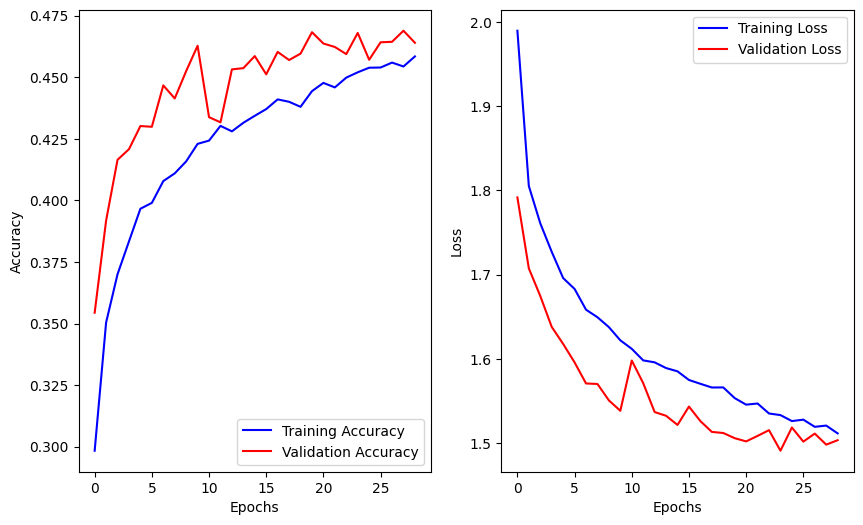

In [17]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history_norm.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history_norm.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_norm.history['loss'], color='b', label='Training Loss')
plt.plot(history_norm.history['val_loss'], color='r', label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

313/313 [==============================] - 2s 7ms/step


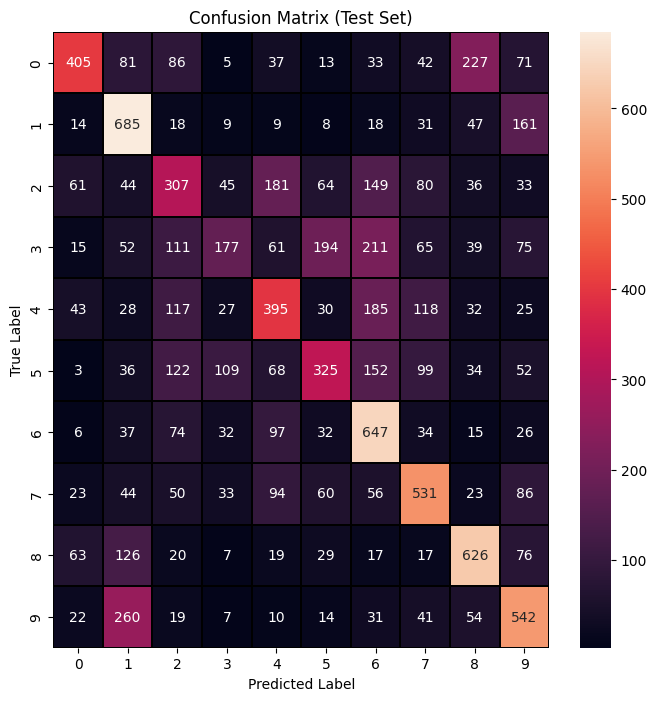

In [42]:
# prompt: plot the above confusion matrix as well as import seaborn as sns

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = np.argmax(model1.predict(xtest), axis=1)
cm1 = confusion_matrix(ytest, y_pred)


import json

with open('cm1.json', 'w') as f:
  json.dump(cm1.tolist(), f)


# Plot the confusion matrix for the test set
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm1, annot=True, linewidth=0.2, linecolor="black", fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [18]:
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy'])
# model2.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model2.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
# model2.compile(optimizer='adagrad', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model2.compile(optimizer='adadelta', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])


In [19]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history_norm2 = model2.fit(xtrain, ytrain,batch_size=64, epochs=50, validation_data=(xtest, ytest), callbacks=[early_stop])

Epoch 1/50
782/782 [==============================] - 26s 30ms/step - loss: 1.8287 - accuracy: 0.3568 - val_loss: 2.0082 - val_accuracy: 0.2857
Epoch 2/50
782/782 [==============================] - 21s 26ms/step - loss: 1.6151 - accuracy: 0.4236 - val_loss: 1.9802 - val_accuracy: 0.3166
Epoch 3/50
782/782 [==============================] - 22s 28ms/step - loss: 1.5364 - accuracy: 0.4519 - val_loss: 1.6589 - val_accuracy: 0.4087
Epoch 4/50
782/782 [==============================] - 22s 28ms/step - loss: 1.4791 - accuracy: 0.4733 - val_loss: 1.6161 - val_accuracy: 0.4215
Epoch 5/50
782/782 [==============================] - 21s 27ms/step - loss: 1.4397 - accuracy: 0.4860 - val_loss: 1.4954 - val_accuracy: 0.4649
Epoch 6/50
782/782 [==============================] - 22s 28ms/step - loss: 1.3947 - accuracy: 0.5050 - val_loss: 1.5583 - val_accuracy: 0.4465
Epoch 7/50
782/782 [==============================] - 22s 28ms/step - loss: 1.3676 - accuracy: 0.5135 - val_loss: 1.5207 - val_accuracy:

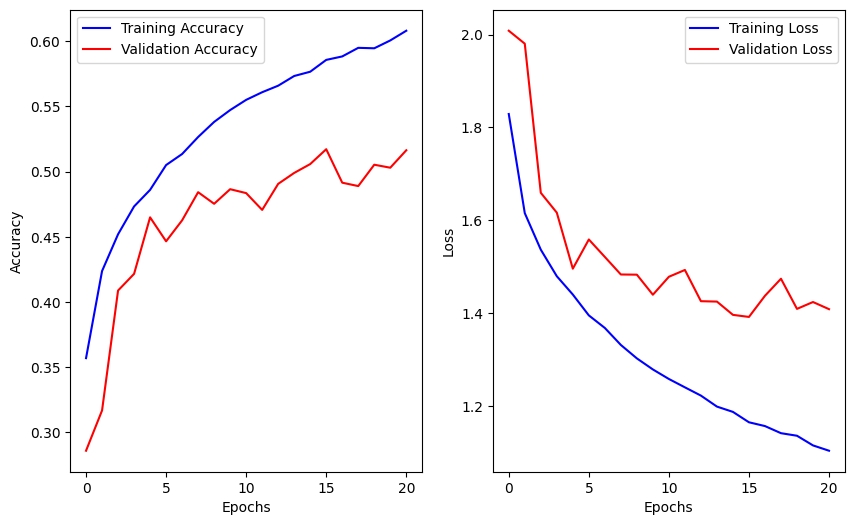

In [20]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history_norm2.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history_norm2.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_norm2.history['loss'], color='b', label='Training Loss')
plt.plot(history_norm2.history['val_loss'], color='r', label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

313/313 [==============================] - 3s 9ms/step


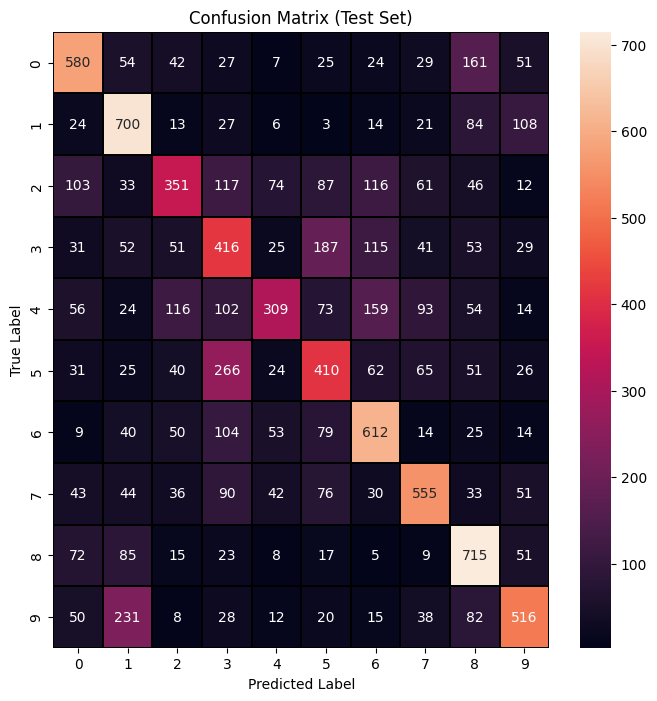

In [43]:
# prompt: plot the above confusion matrix as well as import seaborn as sns

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = np.argmax(model2.predict(xtest), axis=1)
cm2 = confusion_matrix(ytest, y_pred)


import json

with open('cm2.json', 'w') as f:
  json.dump(cm2.tolist(), f)


# Plot the confusion matrix for the test set
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm2, annot=True, linewidth=0.2, linecolor="black", fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [21]:
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= ['accuracy'])
# model3.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model3.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics= ['accuracy'])
# model3.compile(optimizer='adagrad', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])
# model3.compile(optimizer='adadelta', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics= ['accuracy'])


In [22]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)
history_norm3 = model3.fit(xtrain, ytrain,batch_size=64, epochs=50, validation_data=(xtest, ytest), callbacks=[early_stop])

Epoch 1/50
782/782 [==============================] - 384s 487ms/step - loss: 1.5278 - accuracy: 0.4473 - val_loss: 1.1925 - val_accuracy: 0.5810
Epoch 2/50
782/782 [==============================] - 383s 490ms/step - loss: 1.0731 - accuracy: 0.6186 - val_loss: 0.9364 - val_accuracy: 0.6733
Epoch 3/50
782/782 [==============================] - 387s 495ms/step - loss: 0.8914 - accuracy: 0.6879 - val_loss: 0.8698 - val_accuracy: 0.6948
Epoch 4/50
782/782 [==============================] - 384s 491ms/step - loss: 0.7828 - accuracy: 0.7293 - val_loss: 0.7274 - val_accuracy: 0.7501
Epoch 5/50
782/782 [==============================] - 385s 493ms/step - loss: 0.7098 - accuracy: 0.7566 - val_loss: 0.7291 - val_accuracy: 0.7512
Epoch 6/50
782/782 [==============================] - 382s 488ms/step - loss: 0.6479 - accuracy: 0.7775 - val_loss: 0.7225 - val_accuracy: 0.7531
Epoch 7/50
782/782 [==============================] - 369s 472ms/step - loss: 0.5958 - accuracy: 0.7950 - val_loss: 0.6120 -

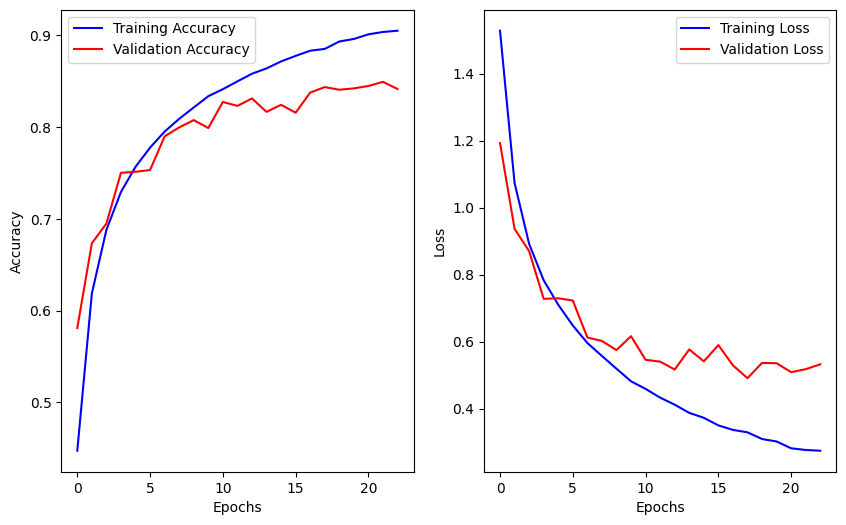

In [23]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history_norm3.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history_norm3.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history_norm3.history['loss'], color='b', label='Training Loss')
plt.plot(history_norm3.history['val_loss'], color='r', label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

313/313 [==============================] - 20s 64ms/step


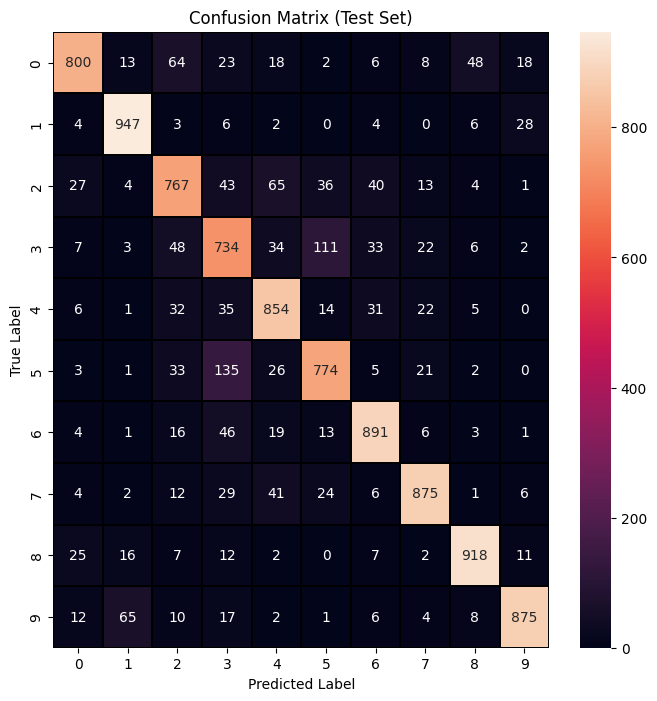

In [44]:
# prompt: plot the above confusion matrix as well as import seaborn as sns

import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

y_pred = np.argmax(model3.predict(xtest), axis=1)
cm3 = confusion_matrix(ytest, y_pred)


import json

with open('cm3.json', 'w') as f:
  json.dump(cm3.tolist(), f)


# Plot the confusion matrix for the test set
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm3, annot=True, linewidth=0.2, linecolor="black", fmt=".0f", ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [45]:
# prompt: open the cm3.json file and convert it back to a 2d array

with open('cm3.json', 'r') as f:
    cm3_array = json.load(f)

# Convert the list of lists to a 2D NumPy array
cm3_array = np.array(cm3_array)
print(cm3_array)


[[800  13  64  23  18   2   6   8  48  18]
 [  4 947   3   6   2   0   4   0   6  28]
 [ 27   4 767  43  65  36  40  13   4   1]
 [  7   3  48 734  34 111  33  22   6   2]
 [  6   1  32  35 854  14  31  22   5   0]
 [  3   1  33 135  26 774   5  21   2   0]
 [  4   1  16  46  19  13 891   6   3   1]
 [  4   2  12  29  41  24   6 875   1   6]
 [ 25  16   7  12   2   0   7   2 918  11]
 [ 12  65  10  17   2   1   6   4   8 875]]


In [26]:

model1.save('model1.h5')
model2.save('model2.h5')
model3.save('model3.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# prompt: how to access and load saved models and predict output too?

# Access and load saved models
model1 = tf.keras.models.load_model('model1.h5')
model2 = tf.keras.models.load_model('model2.h5')
model3 = tf.keras.models.load_model('model3.h5')

xtest_reshaped = xtest.reshape((-1, 28, 28))

# Predict output using the reshaped input
predictions1 = model1.predict(xtest_reshaped)
predictions2 = model2.predict(xtest_reshaped)
predictions3 = model3.predict(xtest_reshaped)

listt1=[]
listt2=[]
listt3=[]

for i in range(len(xtest)):
  # Print the predictions
  # print('Predictions for model1:')
  mod1=np.argmax(predictions1[i])
  if mod1!=ytest[i]:
    listt1.append(i)
  # print('Predictions for model2:')
  mod2=np.argmax(predictions2[i])
  if mod2!=ytest[i]:
    listt2.append(i)
  # print('Predictions for model3:')
  mod3=np.argmax(predictions3[i])
  if mod3!=ytest[i]:
    listt3.append(i)


ValueError: cannot reshape array of size 30720000 into shape (28,28)

In [ ]:
print(listt1)
print(listt2)
print(listt3)

In [29]:
import json

In [30]:
with open('history_norm.json', 'w') as file:
    json.dump(history_norm.history, file)

In [31]:
with open('history_norm2.json', 'w') as file:
    json.dump(history_norm2.history, file)

In [32]:
with open('history_norm3.json', 'w') as file:
    json.dump(history_norm3.history, file)

In [ ]:
plt.imshow(xtest[15])
plt.show()

